In [1]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.10.0


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
#pip install pandas numpy gensim scikit-learn keras

In [16]:
import pandas 
import numpy
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, Dropout, Dense, Embedding, MaxPooling1D, Flatten, Input, LSTM, concatenate
from sklearn.utils import resample

# Your model code goes here


In [17]:
PATH = './'

In [6]:
RANDOM_SEED = 42 # A random seed is a starting point in generating random numbers
numpy.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
# With the seed reset (every time), the same set of numbers will appear every time - make the results more predictable and therefore reproducable 
# If the random seed is not reset, different numbers appear with every invocation.


In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

# load the data set from the train csv files
def load_train_data():
    #create Pandas dataframes from the two csv files
    train_bodies = pandas.read_csv(PATH + "train_bodies.csv", encoding='utf-8')
    train_headlines = pandas.read_csv(PATH + "train_stances.csv", encoding='utf-8')

    #merge the csv files on Body ID so that we can have article headlines, bodies, and stances all in one dataframe together 
    train_data_set = pandas.merge(train_bodies, train_headlines, how='left', on='Body ID')
    stances = {
        'Stance': {
          'agree': 0,
          'disagree': 1,
          'discuss': 2,
          'unrelated': 3,
        }
    }
    train_data_set.replace(stances, inplace=True)
    print("original here")
    print(train_data_set)
    # print(train_data_set['Stance'].value_counts())
   
    # average to 8909 or 3678? because 36545 is a lot but 840 is very small
    # unrelated - 36545, discuss - 8909, agree - 3678, disagree - 840
    data_length = 8909

    # resampling ensures that distribution of classes (in this case, stances) are even - we chose to match them to one of the middle distribution sizes 
    # we want to oversample to better represent minorities classes (agree and disagree) so model has more samples to learn more 
    # also want to undersample majority class (unrelated) so that we don't risk our model skewing towards this class 
    unrelated_resampled = resample(train_data_set.loc[train_data_set['Stance'] == 3], replace = False, n_samples = data_length, random_state = RANDOM_SEED)
    discuss_resampled = resample(train_data_set.loc[train_data_set['Stance'] == 2], replace = False, n_samples = data_length, random_state = RANDOM_SEED)
    agree_resampled = resample(train_data_set.loc[train_data_set['Stance'] == 0], replace=True, n_samples=data_length, random_state=RANDOM_SEED)
    disagree_resampled = resample(train_data_set.loc[train_data_set['Stance'] == 1], replace=True, n_samples=data_length, random_state=RANDOM_SEED)
  
    #merge and shuffle
    all_resampled = [unrelated_resampled, discuss_resampled, agree_resampled, disagree_resampled]
    result = pandas.concat(all_resampled)
    result = result.sample(frac=1)

    print(result['Stance'].value_counts())
    print("result here")
    print(result)

    return result

In [8]:
def load_test_data():     
    #create Pandas dataframes from the two csv files
    train_bodies = pandas.read_csv(PATH + "competition_test_bodies.csv", encoding='utf-8')
    train_headlines = pandas.read_csv(PATH+'competition_test_stances.csv', encoding='utf-8')

    #merge the csv files on Body ID
    test_data_set = pandas.merge(train_bodies, train_headlines, how='left', on='Body ID')
    stances = {
        'Stance': {
          'agree': 0,
          'disagree': 1,
          'discuss': 2,
          'unrelated': 3,
        }
    }
    test_data_set.replace(stances, inplace=True)
    print(test_data_set['Stance'].value_counts())
    # print(test_data_set)
    
    return test_data_set 


In [9]:
import pickle as pkl
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from gensim.models import KeyedVectors

def prepare_data(data_set, length=None):
    # Find the max length of each dataset for padding
    if not length:
        bodies_max_length = data_set['articleBody'].map(lambda x: len(x.split())).max()
        headlines_max_length = data_set['Headline'].map(lambda x: len(x.split())).max()
    else:
        bodies_max_length = length[0]
        headlines_max_length = length[1]

    # Tokenize the data
    bodies_tokenizer = Tokenizer()
    headlines_tokenizer = Tokenizer()

    bodies_tokenizer.fit_on_texts(data_set['articleBody'])
    headlines_tokenizer.fit_on_texts(data_set['Headline'])

    # Save tokenizers
    with open('bodies_tokenizer.pkl', 'wb') as handle:
        pkl.dump(bodies_tokenizer, handle, protocol=pkl.HIGHEST_PROTOCOL)
    with open('headlines_tokenizer.pkl', 'wb') as handle:
        pkl.dump(headlines_tokenizer, handle, protocol=pkl.HIGHEST_PROTOCOL)

    # Convert texts to sequences
    bodies_sequences = bodies_tokenizer.texts_to_sequences(data_set['articleBody'])
    headlines_sequences = headlines_tokenizer.texts_to_sequences(data_set['Headline'])

    # Pad sequences
    bodies_sequences = pad_sequences(bodies_sequences, maxlen=bodies_max_length, padding='post', truncating='post')
    headlines_sequences = pad_sequences(headlines_sequences, maxlen=headlines_max_length, padding='post', truncating='post')

    return bodies_sequences, headlines_sequences, bodies_tokenizer.word_index, headlines_tokenizer.word_index, data_set['Stance']

def create_embeddings(bodies_word_index, headlines_word_index):
    # Load pre-trained word vectors
    word2vec_model = KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin', binary=True)
    
    def get_vector(word):
        return word2vec_model[word] if word in word2vec_model else None

    # Create embeddings matrix
    bodies_embeddings_matrix = np.zeros((len(bodies_word_index) + 1, 300))
    for word, i in bodies_word_index.items():
        embedding_vector = get_vector(word)
        if embedding_vector is not None:
            bodies_embeddings_matrix[i] = embedding_vector

    headlines_embeddings_matrix = np.zeros((len(headlines_word_index) + 1, 300))
    for word, i in headlines_word_index.items():
        embedding_vector = get_vector(word)
        if embedding_vector is not None:
            headlines_embeddings_matrix[i] = embedding_vector

    return bodies_embeddings_matrix, headlines_embeddings_matrix

if __name__ == '__main__':
    # Ensure these functions are defined
    train_data = load_train_data()
    test_data = load_test_data()
    # passing part of data
    train_data_sampled = train_data.sample(frac=0.2, random_state=RANDOM_SEED)

    # bodies_sequences, headlines_sequences, bodies_word_index, headlines_word_index, stances = prepare_data(train_data)
    #part of data
    bodies_sequences, headlines_sequences, bodies_word_index, headlines_word_index, stances = prepare_data(train_data_sampled)
    test_bodies_sequences, test_headlines_sequences, test_bodies_word_index, test_headlines_word_index, test_stances = prepare_data(test_data, [bodies_sequences.shape[1], headlines_sequences.shape[1]])

    bodies_embeddings_matrix, headlines_embeddings_matrix = create_embeddings(bodies_word_index, headlines_word_index)

    bodies_vocab_size = len(bodies_word_index)
    headlines_vocab_size = len(headlines_word_index)


C:\Users\k7adi\AppData\Local\Temp\ipykernel_2200\1231479786.py:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_data_set.replace(stances, inplace=True)
C:\Users\k7adi\AppData\Local\Temp\ipykernel_2200\3934470195.py:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_data_set.replace(stances, inplace=True)


original here
       Body ID                                        articleBody  \
0            0  A small meteorite crashed into a wooded area i...   
1            0  A small meteorite crashed into a wooded area i...   
2            0  A small meteorite crashed into a wooded area i...   
3            0  A small meteorite crashed into a wooded area i...   
4            0  A small meteorite crashed into a wooded area i...   
...        ...                                                ...   
49967     2532  ANN ARBOR, Mich. – A pizza delivery man in Mic...   
49968     2532  ANN ARBOR, Mich. – A pizza delivery man in Mic...   
49969     2532  ANN ARBOR, Mich. – A pizza delivery man in Mic...   
49970     2532  ANN ARBOR, Mich. – A pizza delivery man in Mic...   
49971     2532  ANN ARBOR, Mich. – A pizza delivery man in Mic...   

                                                Headline  Stance  
0      Soldier shot, Parliament locked down after gun...       3  
1      Tourist dubbed ‘

In [10]:
def create_model(embedding_matrix, vocab_size, input_length):
    model = Sequential()  # stack of layers, each has one input and one output that are passed through layers 
    model.add(Embedding(vocab_size + 1,300, weights = [embedding_matrix], trainable=False, input_length=input_length)) # tell model to use word2vec embeddings for words

    # convolutional -> dropout -> pooling
    
    # convolutional: apply a filter to an input to create a feature map that summarizes the presence of detected features in the input
    # dropout: randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting
      # overfitting means that the model learns features of the testing set too well that it can't generalize to testing data and has low testing accuracy but high training accuracy
    # pooling: reduce the dimensions of the feature maps -> reduce number of parameters to learn by summarizing the features present in a region of feature map 

    model.add(Conv1D(64, 5, activation='relu')) # activation function decides if node would fire or not - relu gets rid of negative inputs 
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=4, padding="same"))
    model.add(LSTM(100, activation='tanh', return_sequences=True))


    print(input_length)
    if input_length >= 512:
      print("issue5 starting")
      model.add(Conv1D(512, 3, activation='relu'))
      model.add(Dropout(0.5))
      model.add(MaxPooling1D(pool_size=2,padding="same"))
      model.add(LSTM(100, activation='tanh', return_sequences=True))
      print("issue5")
      
    print("issue6 starting")
    model.add(Conv1D(768, 1, activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2,padding="same"))
    model.add(LSTM(100, activation='tanh', return_sequences=True))
    model.add(LSTM(100, activation='tanh', return_sequences=True))
    model.add(LSTM(100, activation='tanh', return_sequences=True))
    model.add(Flatten())

    return model

4788
issue5 starting
issue5
issue6 starting
40
issue6 starting
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 4788)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 sequential (Sequential)        (None, 29900)        8873844     ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 500)          1821432     ['input_2[0][0]']                
                               

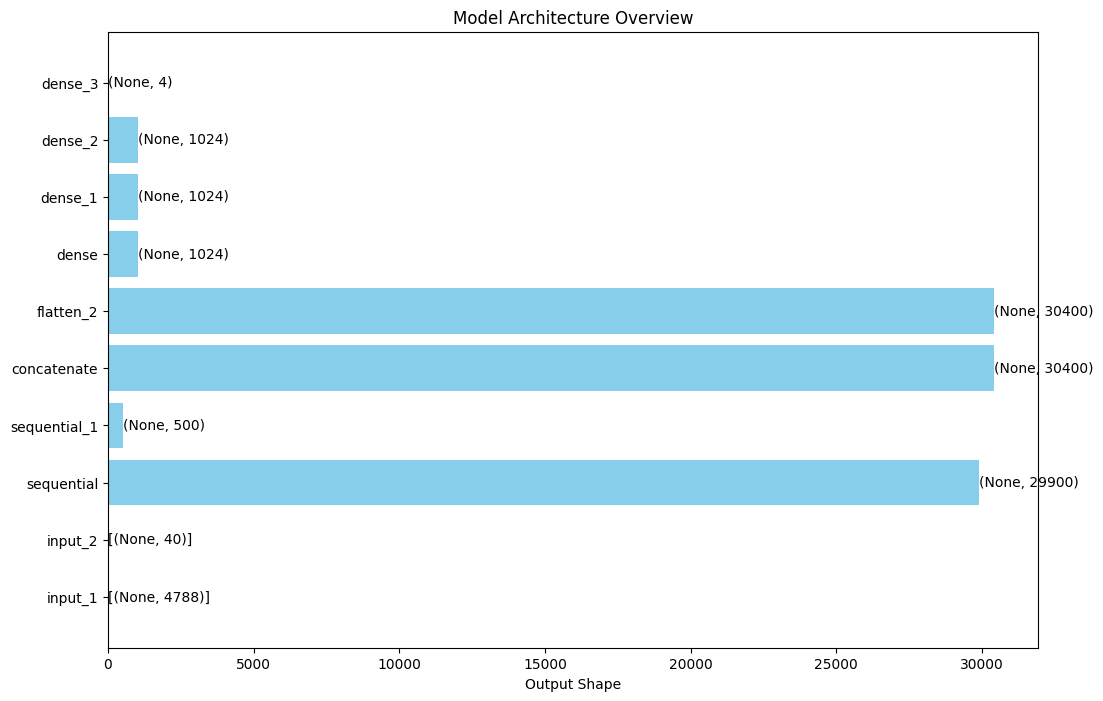

In [11]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Concatenate, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

# Your other code...

bodies_input = tf.keras.layers.Input(shape=(bodies_sequences.shape[1],))
bodies_model = create_model(embedding_matrix=bodies_embeddings_matrix, vocab_size=bodies_vocab_size, input_length=bodies_sequences.shape[1])
bodies_output = bodies_model(bodies_input)

headlines_input = tf.keras.layers.Input(shape=(headlines_sequences.shape[1],))
headlines_model = create_model(embedding_matrix=headlines_embeddings_matrix, vocab_size=headlines_vocab_size, input_length=headlines_sequences.shape[1])
headlines_output = headlines_model(headlines_input)

# Concatenate the models
finalModel = Concatenate()([bodies_output, headlines_output])
finalModel = Flatten()(finalModel)
finalModel = Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001))(finalModel)
finalModel = Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001))(finalModel)
finalModel = Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001))(finalModel)
finalModel = Dense(4, activation='softmax')(finalModel)

# Create the final model
model = Model(inputs=[bodies_input, headlines_input], outputs=finalModel)

# Compile the model
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# Print the summary
print(model.summary())

# Visualize the model using Matplotlib
def plot_model_layers(model):
    layer_names = [layer.name for layer in model.layers]
    layer_shapes = []
    
    for layer in model.layers:
        try:
            layer_shapes.append(layer.output_shape)
        except AttributeError:
            layer_shapes.append((None,))  # Fallback shape for InputLayer or any other issue

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.barh(layer_names, [s[1] if len(s) > 1 else 1 for s in layer_shapes], color='skyblue')

    for i, (name, shape) in enumerate(zip(layer_names, layer_shapes)):
        ax.text(shape[1] + 10 if len(shape) > 1 else 10, i, f'{shape}', va='center')

    ax.set_xlabel('Output Shape')
    ax.set_title('Model Architecture Overview')
    plt.show()

# Call the function to plot the layers of your model
plot_model_layers(model)


In [12]:
import keras
from IPython.display import clear_output
from matplotlib import pyplot as plt
class PlotLearning(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        
        clear_output(wait=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()
        
        plt.show()
        
plot = PlotLearning()

In [13]:
filepath= './' + "test.best.hdf5.keras"

In [14]:
 # print(headlines_sequences[4].size)
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

print(bodies_sequences.shape)
print(headlines_sequences.shape)
print(stances)
onehot_stances = to_categorical(stances)
print(onehot_stances)


# stances_counts = train_data['Stance'].value_counts()
#for part of data
stances_counts = train_data_sampled['Stance'].value_counts()
count_total = stances_counts.sum()
count_unrelated, count_dicuss, count_agree, count_disagree = stances_counts[3], stances_counts[2], stances_counts[0], stances_counts[1]
weight_unrelated = 1/(count_unrelated) * (count_total) / 2.0
weight_discuss = 1/(count_dicuss) * (count_total) / 2.0
weight_agree = 1/(count_agree) * (count_total) / 2.0
weight_disagree = 1/(count_disagree) * (count_total) / 2.0

class_weights = {0: weight_agree, 1: weight_disagree, 2: weight_discuss, 3: weight_unrelated}

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

model.fit([bodies_sequences, headlines_sequences],
              onehot_stances,batch_size=16,
              epochs=10, callbacks=callbacks_list,
              validation_split=0.05, 
              shuffle=True,
              class_weight=class_weights  # Use adjusted class weights
              )

model.save('./' + 'model')


(7127, 4788)
(7127, 40)
34138    1
28559    2
18100    0
33000    3
37095    3
        ..
7221     1
46222    1
18114    1
1398     0
39497    2
Name: Stance, Length: 7127, dtype: int64
[[0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 ...
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]]
Epoch 1/10
424/424 [==============================] - ETA: 0s - loss: 4.0247 - accuracy: 0.3612
Epoch 1: val_accuracy improved from -inf to 0.45378, saving model to .\test.best.hdf5.keras
424/424 [==============================] - 181s 364ms/step - loss: 4.0247 - accuracy: 0.3612 - val_loss: 1.9050 - val_accuracy: 0.4538
Epoch 2/10
424/424 [==============================] - ETA: 0s - loss: 2.7569 - accuracy: 0.4770
Epoch 2: val_accuracy improved from 0.45378 to 0.50700, saving model to .\test.best.hdf5.keras
424/424 [==============================] - 149s 352ms/step - loss: 2.7569 - accuracy: 0.4770 - val_loss: 1.5286 - val_accuracy: 0.5070
Epoch 3/10
424/424 [==============================] - ETA: 0s - loss:

INFO:tensorflow:Assets written to: ./model\assets


INFO:tensorflow:Assets written to: ./model\assets


In [15]:
model.load_weights('./' + "test.best.hdf5.keras")

from tensorflow.keras.utils import to_categorical
test_onehot_stances = to_categorical(test_stances)
print(len(bodies_sequences))
print(len(test_bodies_sequences), test_headlines_sequences[0], test_onehot_stances[0])
model.evaluate([test_bodies_sequences, test_headlines_sequences], test_onehot_stances)


7127
25413 [  13 1250  219    3  706    1  829  267   63  572    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0] [0. 0. 0. 1.]
795/795 [==============================] - 174s 218ms/step - loss: 1.5070 - accuracy: 0.1881


[1.5070143938064575, 0.18805335462093353]